Инициализируем необходимые функции и импорты

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return


Загрузим данные и выведем графики временных рядов

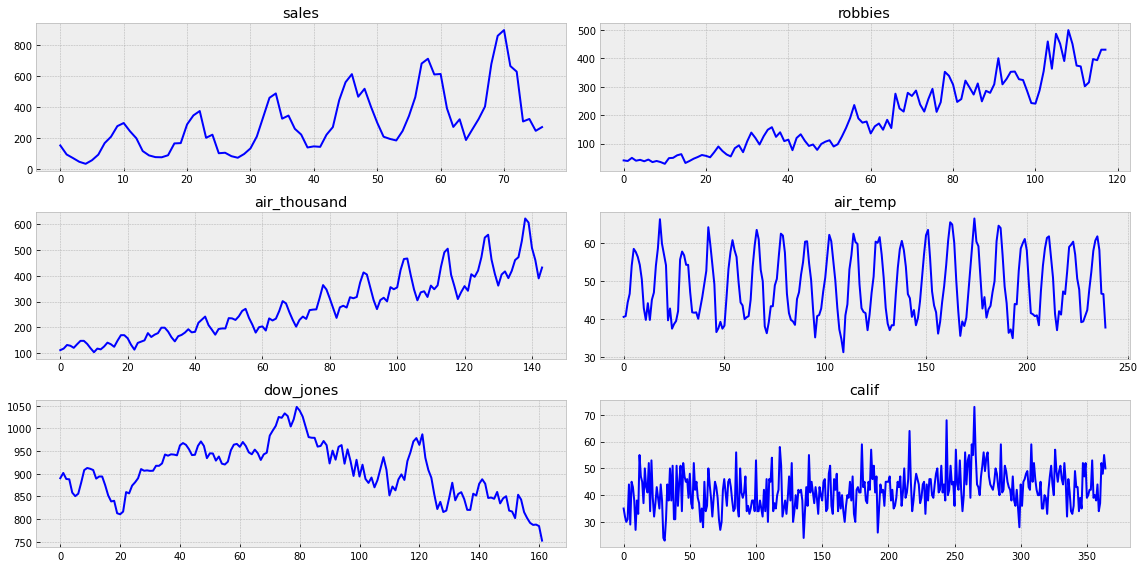

In [2]:
sales_of_company_x = pd.read_csv("./monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("./monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("./international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("./mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("./weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("./daily-total-female-births-in-cal.csv")

all_series = {
    "sales": sales_of_company_x["Count"],
    "robbies": robberies_in_boston["Count"],
    "air_thousand": airlines_passengers["Count"],
    "air_temp": mean_monthly_temp["Deg"],
    "dow_jones": dowjones_closing["Close"],
    "calif": female_births["Count"]
}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()

Изучив первый график 'sales', мы видим, что присутствует тренд и сезонность. Вычислим сезонность обучив модель авторегрессии.

In [4]:
mdl = smt.AutoReg(all_series["sales"],lags=30).fit()
print(mdl.params)

const        55.319899
Count.L1      0.285768
Count.L2      0.560249
Count.L3     -0.015468
Count.L4     -0.237443
Count.L5     -0.191707
Count.L6     -0.000456
Count.L7     -0.245370
Count.L8      0.005371
Count.L9      0.199487
Count.L10     0.066383
Count.L11     0.639971
Count.L12     0.499304
Count.L13    -0.561095
Count.L14    -0.677428
Count.L15     0.043148
Count.L16     0.610834
Count.L17     0.235545
Count.L18    -0.254203
Count.L19     0.278913
Count.L20    -0.167145
Count.L21    -0.146942
Count.L22    -0.107766
Count.L23    -0.689764
Count.L24     0.699263
Count.L25     0.152080
Count.L26     0.169825
Count.L27     0.040743
Count.L28    -0.692993
Count.L29    -0.000189
Count.L30     0.500212
dtype: float64


Лаг под номером 14 имеет наибольшее значение, значит сезонность равна 14. Уберем тренд и сезонность с помощью дифференцирования.

Results of Dickey-Fuller Test:
Test Statistic                -7.523577e+00
p-value                        3.735274e-11
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


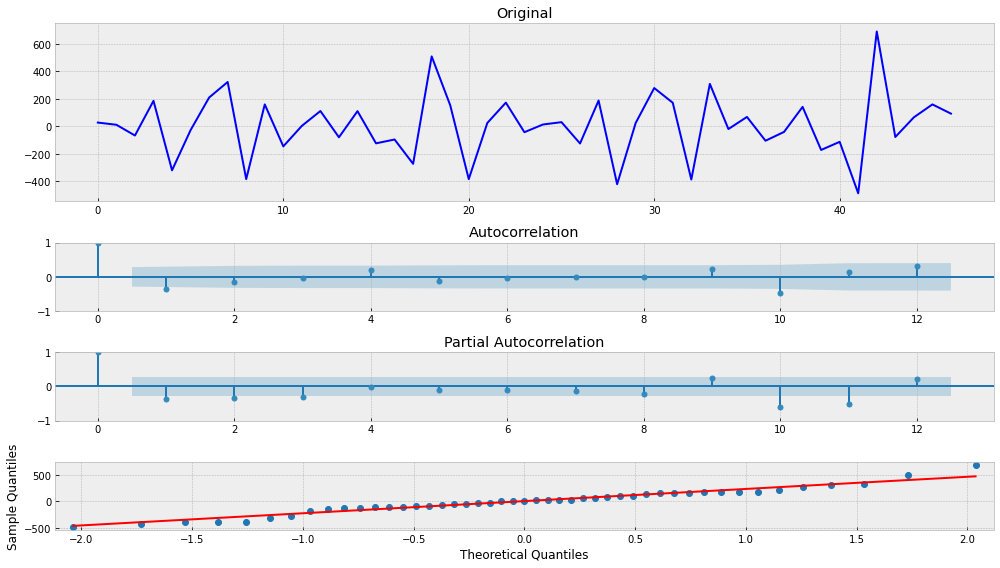

In [7]:
all_series["sales"] = np.diff(all_series["sales"])
all_series["sales"] = all_series["sales"][14:] - all_series["sales"][:-14]
tsplot(all_series["sales"], lags=12)

Получаем стационарный ряд с p-value = 3.735274e-11.

Далее рассмотрим два ряда, которые стационарны без преобразований.

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


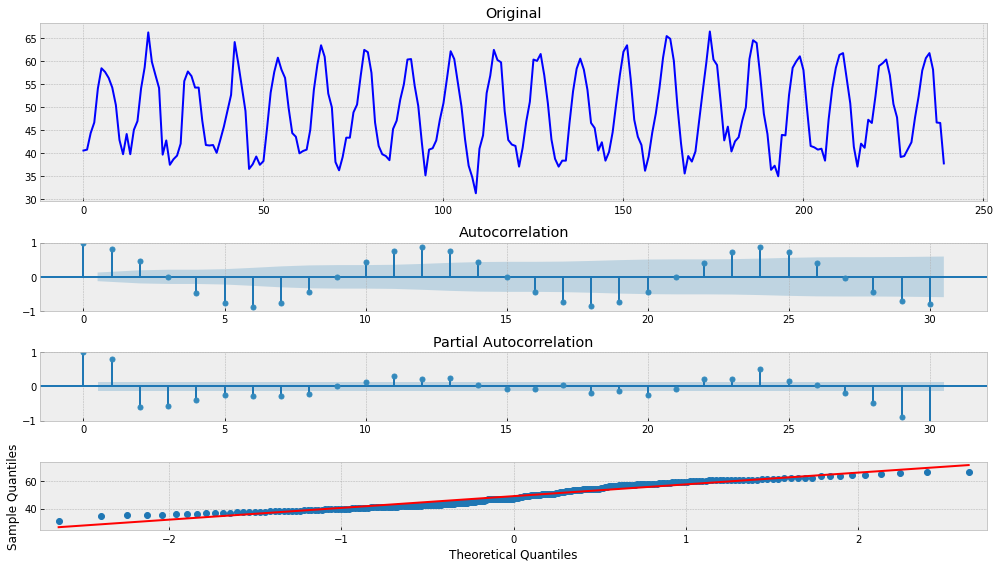

In [8]:
tsplot(all_series["air_temp"], lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


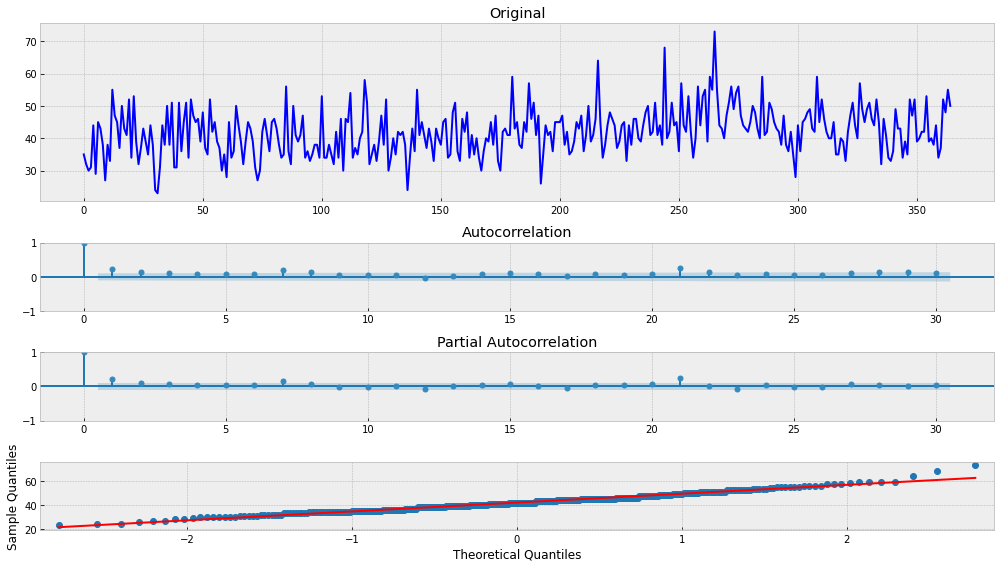

In [9]:
tsplot(all_series["calif"], lags=30)

Два следующих ряда становятся стационарными после удаления тренда.

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


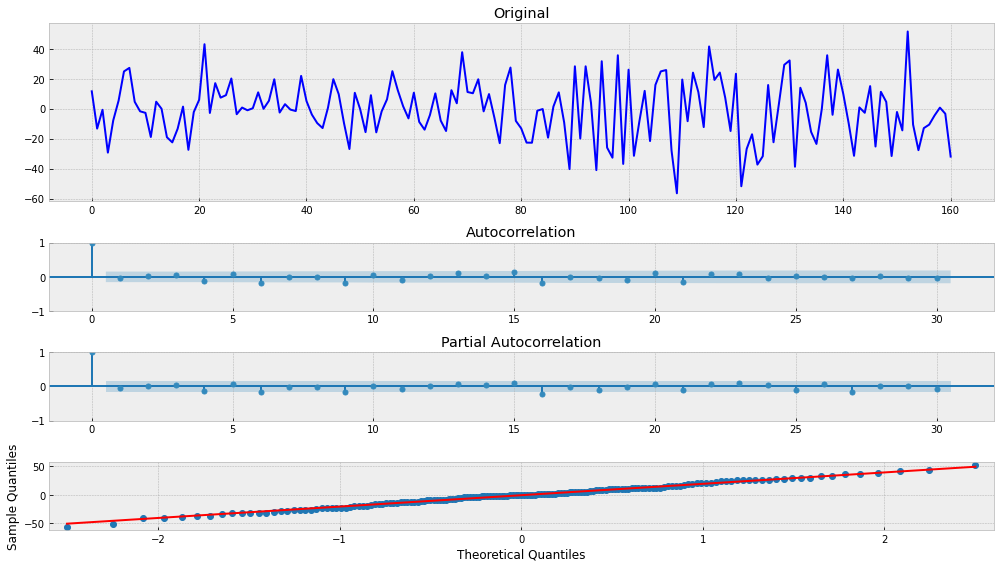

In [10]:
all_series["dow_jones"] = np.diff(all_series["dow_jones"])
tsplot(all_series["dow_jones"], lags=30)

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


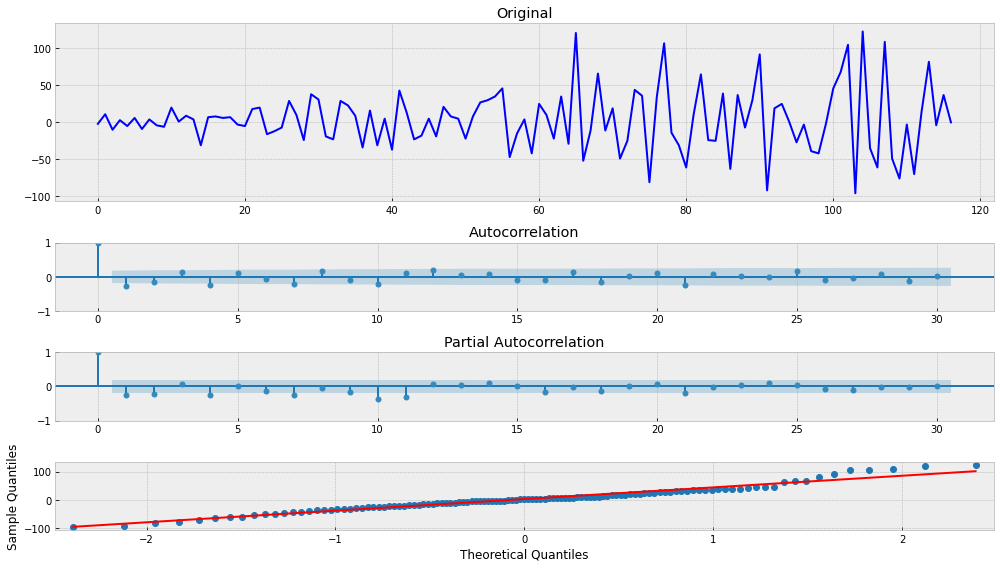

In [11]:
all_series["robbies"] = np.diff(all_series["robbies"])
tsplot(all_series["robbies"], lags=30)

Последний временной ряд становится стационарными после удаления тренда и сезонности, равной 12.

In [12]:
mdl = smt.AutoReg(all_series["air_thousand"],lags=30).fit()
print(mdl.params)

const        4.962928
Count.L1     0.508594
Count.L2     0.273485
Count.L3     0.074918
Count.L4    -0.183118
Count.L5     0.244120
Count.L6    -0.011227
Count.L7    -0.072447
Count.L8    -0.063233
Count.L9     0.350078
Count.L10   -0.379460
Count.L11   -0.026990
Count.L12    0.746943
Count.L13   -0.197418
Count.L14   -0.332671
Count.L15    0.101959
Count.L16   -0.112333
Count.L17   -0.086036
Count.L18   -0.127740
Count.L19    0.221745
Count.L20   -0.110661
Count.L21   -0.166932
Count.L22    0.212197
Count.L23    0.267388
Count.L24    0.137293
Count.L25   -0.133251
Count.L26   -0.210576
Count.L27   -0.037831
Count.L28    0.235713
Count.L29   -0.043692
Count.L30   -0.062029
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


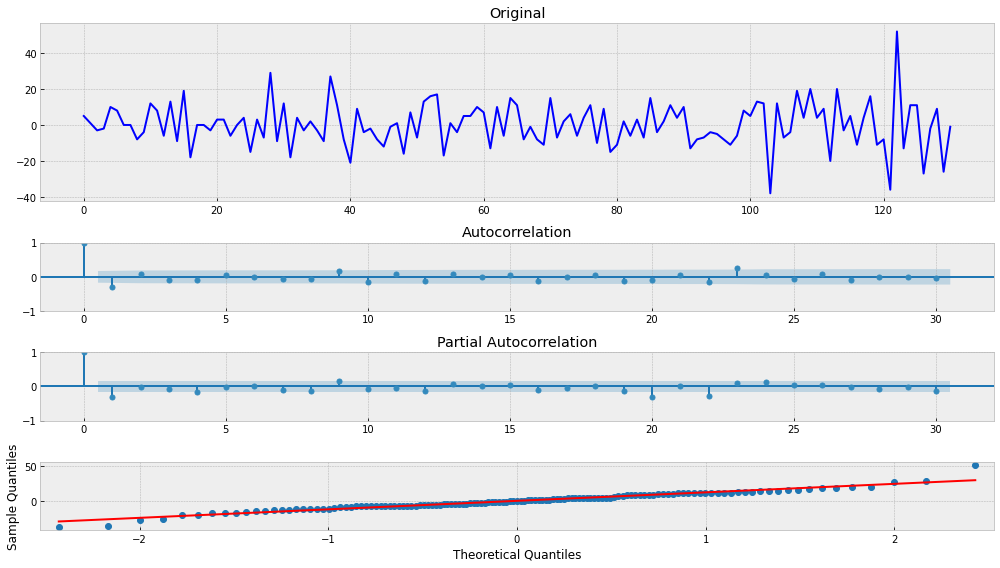

In [13]:
all_series["air_thousand"] = np.diff(all_series["air_thousand"])
all_series["air_thousand"] = all_series["air_thousand"][12:] - all_series["air_thousand"][:-12]
tsplot(all_series["air_thousand"], lags=30)